In [2]:
import pandas as pd
import xarray as xr
import rasterio as rio
import numpy as np
import rioxarray
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
md_df = pd.read_csv('md_processing_decisions.csv').iloc[:, 0:9]
md_df['survey_name'] = md_df['survey_name'].str.strip()

In [4]:
def mean_aspect(array):
    # Convert to radians
    aspects_rad = np.deg2rad(array)

    # Calculate mean aspect
    sin_mean = np.mean(np.sin(aspects_rad))
    cos_mean = np.mean(np.cos(aspects_rad))
    
    # Convert back to degrees
    mean_aspect = np.rad2deg(np.arctan2(sin_mean, cos_mean))
    
    # Adjust the result to lie between 0 and 360
    if mean_aspect < 0:
        mean_aspect += 360

    return mean_aspect

def std_aspect(array):
    aspects_rad = np.deg2rad(array)

    # Calculate mean aspect in Cartesian coordinates
    sin_mean = np.mean(np.sin(aspects_rad))
    cos_mean = np.mean(np.cos(aspects_rad))
    
    # Calculate the length of the mean resultant vector
    R = np.sqrt(sin_mean**2 + cos_mean**2)
    
    # Calculate the circular standard deviation
    circ_std_dev = np.sqrt(-2 * np.log(R))
    
    # Convert back to degrees
    circ_std_dev_deg = np.rad2deg(circ_std_dev)

    return circ_std_dev_deg

In [5]:
def random_sample(array, count=40):
    non_nan_values = array[~np.isnan(array)]
    if len(non_nan_values) >= count:
        selected_values = np.random.choice(non_nan_values, size=count, replace=False)
    else:
        print("There are fewer array values than the specified count")
        return non_nan_values

    return selected_values

In [66]:
md_area_dic = {}
stable_area_dic = {}
moving_area_dic = {}
bank_area_dic = {}
landslide_area_dic = {}
elev_mean_dic = {}
aspect_mean_dic = {}
slope_mean_dic = {}

asc_mask_area_dic = {}
des_mask_area_dic = {}
combined_mask_area_dic = {}

asc_coherence_dic = {}
des_coherence_dic = {}
asc_coherence_stable_dic = {}
des_coherence_stable_dic = {}
mean_coherence_change_dic = {}
ice_area_dic = {}
mean_coherence_change_stable_dic = {}
ice_area_stable_dic = {}

asc_veloc_sample = np.array([])
des_veloc_sample = np.array([])
ud_veloc_sample = np.array([])
ew_veloc_sample = np.array([])
combined_veloc_sample = np.array([])

asc_veloc_sample_stable = np.array([])
des_veloc_sample_stable = np.array([])
ud_veloc_sample_stable = np.array([])
ew_veloc_sample_stable = np.array([])
combined_veloc_sample_stable = np.array([])

asc_veloc_all_dic = {}
des_veloc_all_dic = {}
ud_veloc_all_dic = {}
ew_veloc_all_dic = {}
combined_veloc_all_dic = {}

asc_veloc_all_stable_dic = {}
des_veloc_all_stable_dic = {}
ud_veloc_all_stable_dic = {}
ew_veloc_all_stable_dic = {}
combined_veloc_all_stable_dic = {}

asc_veloc_median_dic = {}
des_veloc_median_dic = {}
ud_veloc_median_dic = {}
ew_veloc_median_dic = {}
combined_veloc_median_dic = {}

asc_veloc_mean_dic = {}
des_veloc_mean_dic = {}
ud_veloc_mean_dic = {}
ew_veloc_mean_dic = {}
combined_veloc_mean_dic = {}

asc_veloc_mean_stable_dic = {}
des_veloc_mean_stable_dic = {}
ud_veloc_mean_stable_dic = {}
ew_veloc_mean_stable_dic = {}
combined_veloc_mean_stable_dic = {}

asc_veloc_mean_landslide_dic = {}
des_veloc_mean_landslide_dic = {}
ud_veloc_mean_landslide_dic = {}
ew_veloc_mean_landslide_dic = {}
combined_veloc_mean_landslide_dic = {}

asc_veloc_mean_bank_dic = {}
des_veloc_mean_bank_dic = {}
ud_veloc_mean_bank_dic = {}
ew_veloc_mean_bank_dic = {}
combined_veloc_mean_bank_dic = {}

asc_veloc_75_dic = {}
des_veloc_75_dic = {}
ud_veloc_75_dic = {}
ew_veloc_75_dic = {}
combined_veloc_75_dic = {}

asc_veloc_max_dic = {}
des_veloc_max_dic = {}
ud_veloc_max_dic = {}
ew_veloc_max_dic = {}
combined_veloc_max_dic = {}

asc_veloc_max_stable_dic = {}
des_veloc_max_stable_dic = {}
ud_veloc_max_stable_dic = {}
ew_veloc_max_stable_dic = {}
combined_veloc_max_stable_dic = {}

asc_veloc_max_bank_dic = {}
des_veloc_max_bank_dic = {}
ud_veloc_max_bank_dic = {}
ew_veloc_max_bank_dic = {}
combined_veloc_max_bank_dic = {}

# cop30_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/all_dams_analysis/terrain/cop30_utm.tif').squeeze()
# aspect_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/all_dams_analysis/terrain/cop30_aspect.tif').squeeze()
# slope_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/all_dams_analysis/terrain/cop30_slope.tif').squeeze()

for i, row in md_df.iterrows():
    print(row.survey_name)
    md_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_md.shp')
    stable_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_stable.shp').dissolve().to_crs(md_gdf.crs)
    md_area_dic[f'{row.survey_name}'] = md_gdf.area.item()
    stable_area_dic[f'{row.survey_name}'] = stable_gdf.area.item()

    # md_gdf_reproj = md_gdf.to_crs(cop30_ds.rio.crs)
    # elev_mean_dic[f'{row.survey_name}'] = cop30_ds.rio.clip(md_gdf_reproj.geometry, crs=md_gdf_reproj.crs).band_data.mean().item()
    # aspect_mean_dic[f'{row.survey_name}'] = mean_aspect(aspect_ds.rio.clip(md_gdf_reproj.geometry, crs=md_gdf_reproj.crs).band_data).item()
    # slope_mean_dic[f'{row.survey_name}'] = slope_ds.rio.clip(md_gdf_reproj.geometry, crs=md_gdf_reproj.crs).band_data.mean().item()

    asc_mask_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_asc_valid.tif').squeeze()
    des_mask_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_des_valid.tif').squeeze()
    combined_mask_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_combined_valid.tif').squeeze()
    asc_mask_area_dic[f'{row.survey_name}'] = np.invert(asc_mask_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.astype('bool')).sum().item()*20*20
    combined_mask_area_dic[f'{row.survey_name}'] = np.invert(combined_mask_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.astype('bool')).sum().item()*20*20
    des_mask_area_dic[f'{row.survey_name}'] = np.invert(des_mask_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.astype('bool')).sum().item()*20*20

    asc_coherence_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_asc_mean_coherence.tif').squeeze()
    des_coherence_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_des_mean_coherence.tif').squeeze()
    asc_coherence_dic[f'{row.survey_name}'] = asc_coherence_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    des_coherence_dic[f'{row.survey_name}'] = des_coherence_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    asc_coherence_stable_dic[f'{row.survey_name}'] = asc_coherence_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.mean().item()
    des_coherence_stable_dic[f'{row.survey_name}'] = des_coherence_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.mean().item()

    coherence_change_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_seasonal_coherence_change.tif').squeeze().rio.write_crs(md_gdf.crs)
    mean_coherence_change_dic[f'{row.survey_name}'] = coherence_change_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    ice_area_dic[f'{row.survey_name}'] = ((coherence_change_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data > 0.03).sum()*20*20).item()
    mean_coherence_change_stable_dic[f'{row.survey_name}'] = coherence_change_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.mean().item()
    ice_area_stable_dic[f'{row.survey_name}'] = ((coherence_change_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data > 0.03).sum()*20*20).item()

    asc_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_asc_median_velocity.tif').squeeze()
    des_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_des_median_velocity.tif').squeeze()
    ud_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_ud_median_velocity.tif').squeeze()
    ew_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_ew_median_velocity.tif').squeeze()
    combined_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_combined_median_velocity.tif').squeeze()

    asc_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    des_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    ud_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    ew_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    combined_veloc_mean_stable_dic[f'{row.survey_name}'] = combined_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()

    asc_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    des_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    ud_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    ew_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    combined_veloc_max_stable_dic[f'{row.survey_name}'] = combined_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data.max().item()

    try:
        landslide_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_landslide.shp').dissolve()
        landslide_area_dic[f'{row.survey_name}'] = landslide_gdf.area.item()
    except:
        pass

    else:
        asc_veloc_mean_landslide_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
        des_veloc_mean_landslide_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
        ud_veloc_mean_landslide_dic[f'{row.survey_name}'] = ud_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
        ew_veloc_mean_landslide_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
        combined_veloc_mean_landslide_dic[f'{row.survey_name}'] = combined_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    
    try:
        moving_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_moving.shp').dissolve()

    except:
        pass

    else:
        moving_area_dic[f'{row.survey_name}'] = moving_gdf.area.item()
        
        # sample each veloc map
        asc_veloc_sample_stable = np.append(asc_veloc_sample_stable, random_sample(asc_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values))
        des_veloc_sample_stable = np.append(des_veloc_sample_stable, random_sample(des_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values))
        ud_veloc_sample_stable = np.append(ud_veloc_sample_stable, random_sample(ud_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values))
        ew_veloc_sample_stable = np.append(ew_veloc_sample_stable, random_sample(ew_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values))
        combined_veloc_sample_stable = np.append(combined_veloc_sample_stable, random_sample(combined_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values))

        # sample each veloc map
        asc_veloc_sample = np.append(asc_veloc_sample, random_sample(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values))
        des_veloc_sample = np.append(des_veloc_sample, random_sample(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values))
        ud_veloc_sample = np.append(ud_veloc_sample, random_sample(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values))
        ew_veloc_sample = np.append(ew_veloc_sample, random_sample(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values))
        combined_veloc_sample = np.append(combined_veloc_sample, random_sample(combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values))

        asc_veloc_all_dic[f'{row.survey_name}'] = asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values.flatten()*100
        des_veloc_all_dic[f'{row.survey_name}'] = des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values.flatten()*100
        ud_veloc_all_dic[f'{row.survey_name}'] = ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values.flatten()*100
        ew_veloc_all_dic[f'{row.survey_name}'] = ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values.flatten()*100
        combined_veloc_all_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.values.flatten()*100

        asc_veloc_all_stable_dic[f'{row.survey_name}'] = asc_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values.flatten()*100
        des_veloc_all_stable_dic[f'{row.survey_name}'] = des_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values.flatten()*100
        ud_veloc_all_stable_dic[f'{row.survey_name}'] = ud_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values.flatten()*100
        ew_veloc_all_stable_dic[f'{row.survey_name}'] = ew_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values.flatten()*100
        combined_veloc_all_stable_dic[f'{row.survey_name}'] = combined_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.values.flatten()*100
        
        asc_veloc_median_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        des_veloc_median_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        ud_veloc_median_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        ew_veloc_median_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        combined_veloc_median_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.median().item()
    
        asc_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        des_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        ud_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        ew_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        combined_veloc_mean_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.mean().item()
    
        asc_veloc_75_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        des_veloc_75_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        ud_veloc_75_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        ew_veloc_75_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        combined_veloc_75_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.quantile(q=0.75).item()
    
        asc_veloc_max_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        des_veloc_max_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        ud_veloc_max_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        ew_veloc_max_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        combined_veloc_max_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.max().item()
    
    try:
        bank_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_bank_movement.shp').dissolve()

    except:
        continue

    else:
        bank_area_dic[f'{row.survey_name}'] = bank_gdf.area.item()
    
        asc_veloc_mean_bank_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).mean().item()
        des_veloc_mean_bank_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).mean().item()
        ud_veloc_mean_bank_dic[f'{row.survey_name}'] = ud_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.mean().item()
        ew_veloc_mean_bank_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).mean().item()
        combined_veloc_mean_bank_dic[f'{row.survey_name}'] = combined_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.mean().item()
    
        asc_veloc_max_bank_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).max().item()
        des_veloc_max_bank_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).max().item()
        ud_veloc_max_bank_dic[f'{row.survey_name}'] = ud_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.min().item()
        ew_veloc_max_bank_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).max().item()
        combined_veloc_max_bank_dic[f'{row.survey_name}'] = combined_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.max().item()

rolpa
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
barun
imja
lumding
chamlang_south
thugali
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
nagma
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
chamlang_north
muli_tal
There are fewer array values than the specified count
There are fewer array values than the specified count
There are fewer array values than the specified count
Ther

In [26]:
md_df['area'] = md_df['survey_name'].map(md_area_dic)
md_df['stable_area'] = md_df['survey_name'].map(stable_area_dic)
md_df['moving_area'] = md_df['survey_name'].map(moving_area_dic)
md_df['bank_area'] = md_df['survey_name'].map(bank_area_dic)
md_df['landslide_area'] = md_df['survey_name'].map(landslide_area_dic)
# md_df['mean_elevation'] = md_df['survey_name'].map(elev_mean_dic)
# md_df['mean_aspect'] = md_df['survey_name'].map(aspect_mean_dic)
# md_df['mean_slope'] = md_df['survey_name'].map(slope_mean_dic)

md_df['asc_mask_area'] = md_df['survey_name'].map(asc_mask_area_dic)
md_df['des_mask_area'] = md_df['survey_name'].map(des_mask_area_dic)
md_df['combined_mask_area'] = md_df['survey_name'].map(combined_mask_area_dic)

md_df['asc_coherence'] = md_df['survey_name'].map(asc_coherence_dic)
md_df['des_coherence'] = md_df['survey_name'].map(des_coherence_dic)
md_df['asc_coherence_stable'] = md_df['survey_name'].map(asc_coherence_stable_dic)
md_df['des_coherence_stable'] = md_df['survey_name'].map(des_coherence_stable_dic)

md_df['coherence_change_mean'] = md_df['survey_name'].map(mean_coherence_change_dic)
md_df['ice_area'] = md_df['survey_name'].map(ice_area_dic)
md_df['coherence_change_mean_stable'] = md_df['survey_name'].map(mean_coherence_change_stable_dic)
md_df['ice_area_stable'] = md_df['survey_name'].map(ice_area_stable_dic)

md_df['asc_median_veloc'] = md_df['survey_name'].map(asc_veloc_median_dic)
md_df['des_median_veloc'] = md_df['survey_name'].map(des_veloc_median_dic)
md_df['ud_median_veloc'] = md_df['survey_name'].map(ud_veloc_median_dic)
md_df['ew_median_veloc'] = md_df['survey_name'].map(ew_veloc_median_dic)
md_df['combined_median_veloc'] = md_df['survey_name'].map(combined_veloc_median_dic)

md_df['asc_mean_veloc'] = md_df['survey_name'].map(asc_veloc_mean_dic)
md_df['des_mean_veloc'] = md_df['survey_name'].map(des_veloc_mean_dic)
md_df['ud_mean_veloc'] = md_df['survey_name'].map(ud_veloc_mean_dic)
md_df['ew_mean_veloc'] = md_df['survey_name'].map(ew_veloc_mean_dic)
md_df['combined_mean_veloc'] = md_df['survey_name'].map(combined_veloc_mean_dic)

md_df['asc_mean_veloc_stable'] = md_df['survey_name'].map(asc_veloc_mean_stable_dic)
md_df['des_mean_veloc_stable'] = md_df['survey_name'].map(des_veloc_mean_stable_dic)
md_df['ud_mean_veloc_stable'] = md_df['survey_name'].map(ud_veloc_mean_stable_dic)
md_df['ew_mean_veloc_stable'] = md_df['survey_name'].map(ew_veloc_mean_stable_dic)
md_df['combined_mean_veloc_stable'] = md_df['survey_name'].map(combined_veloc_mean_stable_dic)

md_df['asc_mean_veloc_bank'] = md_df['survey_name'].map(asc_veloc_mean_bank_dic)
md_df['des_mean_veloc_bank'] = md_df['survey_name'].map(des_veloc_mean_bank_dic)
md_df['ud_mean_veloc_bank'] = md_df['survey_name'].map(ud_veloc_mean_bank_dic)
md_df['ew_mean_veloc_bank'] = md_df['survey_name'].map(ew_veloc_mean_bank_dic)
md_df['combined_mean_veloc_bank'] = md_df['survey_name'].map(combined_veloc_mean_bank_dic)

md_df['asc_mean_veloc_landslide'] = md_df['survey_name'].map(asc_veloc_mean_landslide_dic)
md_df['des_mean_veloc_landslide'] = md_df['survey_name'].map(des_veloc_mean_landslide_dic)
md_df['ud_mean_veloc_landslide'] = md_df['survey_name'].map(ud_veloc_mean_landslide_dic)
md_df['ew_mean_veloc_landslide'] = md_df['survey_name'].map(ew_veloc_mean_landslide_dic)
md_df['combined_mean_veloc_landslide'] = md_df['survey_name'].map(combined_veloc_mean_landslide_dic)

md_df['asc_75_veloc'] = md_df['survey_name'].map(asc_veloc_75_dic)
md_df['des_75_veloc'] = md_df['survey_name'].map(des_veloc_75_dic)
md_df['ud_75_veloc'] = md_df['survey_name'].map(ud_veloc_75_dic)
md_df['ew_75_veloc'] = md_df['survey_name'].map(ud_veloc_75_dic)
md_df['combined_75_veloc'] = md_df['survey_name'].map(combined_veloc_75_dic)

md_df['asc_max_veloc'] = md_df['survey_name'].map(asc_veloc_max_dic)
md_df['des_max_veloc'] = md_df['survey_name'].map(des_veloc_max_dic)
md_df['ud_max_veloc'] = md_df['survey_name'].map(ud_veloc_max_dic)
md_df['ew_max_veloc'] = md_df['survey_name'].map(ew_veloc_max_dic)
md_df['combined_max_veloc'] = md_df['survey_name'].map(combined_veloc_max_dic)

md_df['asc_max_veloc_stable'] = md_df['survey_name'].map(asc_veloc_max_stable_dic)
md_df['des_max_veloc_stable'] = md_df['survey_name'].map(des_veloc_max_stable_dic)
md_df['ud_max_veloc_stable'] = md_df['survey_name'].map(ud_veloc_max_stable_dic)
md_df['ew_max_veloc_stable'] = md_df['survey_name'].map(ew_veloc_max_stable_dic)
md_df['combined_max_veloc_stable'] = md_df['survey_name'].map(combined_veloc_max_stable_dic)

md_df['asc_max_veloc_bank'] = md_df['survey_name'].map(asc_veloc_max_bank_dic)
md_df['des_max_veloc_bank'] = md_df['survey_name'].map(des_veloc_max_bank_dic)
md_df['ud_max_veloc_bank'] = md_df['survey_name'].map(ud_veloc_max_bank_dic)
md_df['ew_max_veloc_bank'] = md_df['survey_name'].map(ew_veloc_max_bank_dic)
md_df['combined_max_veloc_bank'] = md_df['survey_name'].map(combined_veloc_max_bank_dic)

/tmp/ipykernel_783/2721442708.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(slow_labels, rotation=45)
/tmp/ipykernel_783/2721442708.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(fast_labels, rotation=45)
/tmp/ipykernel_783/2721442708.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(slow_labels, rotation=45)
/tmp/ipykernel_783/2721442708.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(fast_labels, rotation=45)


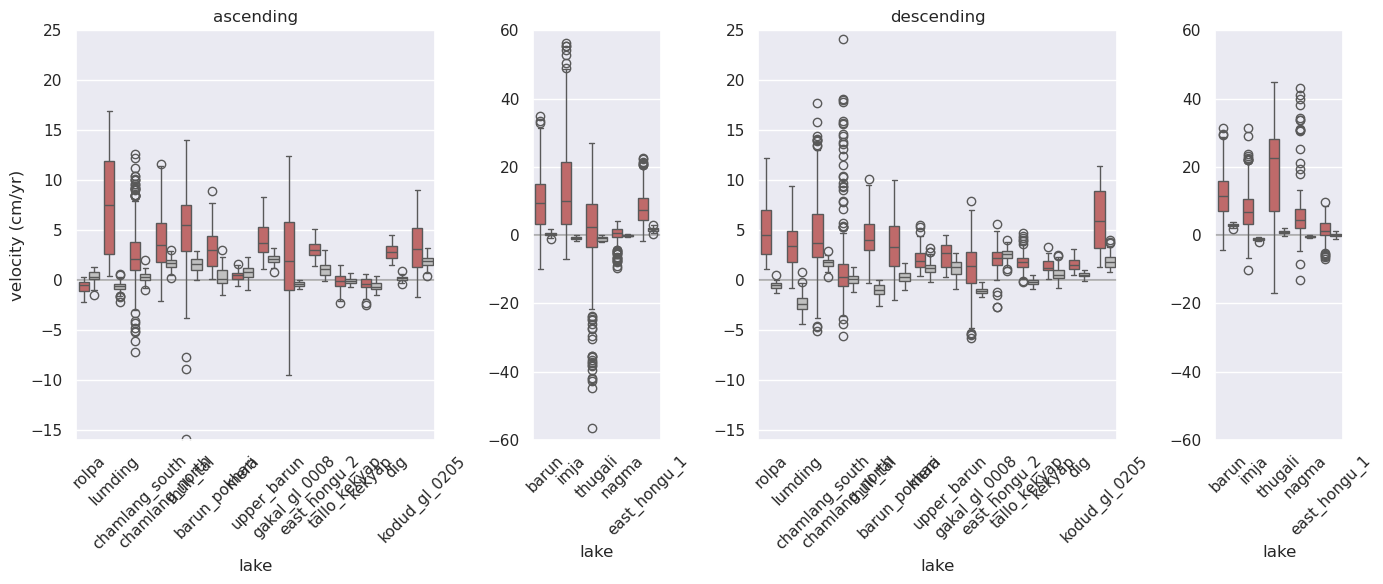

In [155]:
asc_dams_df = pd.DataFrame.from_dict(asc_veloc_all_dic, orient='index').transpose()
asc_dams_df['type'] = 'dam'
asc_stable_df = pd.DataFrame.from_dict(asc_veloc_all_stable_dic, orient='index').transpose()
asc_stable_df['type'] = 'stable'
asc_df = pd.concat([asc_dams_df, asc_stable_df])
asc_df_slow = asc_df.drop(['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1'], axis=1)
asc_df_slow = asc_df_slow.melt(id_vars='type')
asc_df_fast = asc_df[['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1', 'type']]
asc_df_fast = asc_df_fast.melt(id_vars='type')

des_dams_df = pd.DataFrame.from_dict(des_veloc_all_dic, orient='index').transpose()
des_dams_df['type'] = 'dam'
des_stable_df = pd.DataFrame.from_dict(des_veloc_all_stable_dic, orient='index').transpose()
des_stable_df['type'] = 'stable'
des_df = pd.concat([des_dams_df, des_stable_df])
des_df_slow = des_df.drop(['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1'], axis=1)
des_df_slow = des_df_slow.melt(id_vars='type')
des_df_fast = des_df[['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1', 'type']]
des_df_fast = des_df_fast.melt(id_vars='type')

colors = ['indianred', 'silver']
slow_labels = ['rolpa', 'lumding','chamlang_south','chamlang_north',
               'muli_tal','barun_pokhari','mera','upper_barun','gakal_gl_0008',
               'east_hongu_2','tallo_kekyap','kekyap','dig','kodud_gl_0205']
fast_labels = ['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1']

f, ax = plt.subplots(1, 4, figsize=(14, 6), gridspec_kw={'width_ratios': [2.8, 1, 2.8, 1]})
ax[0].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0], y='value', x='variable', hue='type', data=asc_df_slow, palette=colors, legend=False)
ax[0].set_title('ascending')
ax[0].set_xlabel('lake')
ax[0].set_ylim(-16, 25)
ax[0].set_ylabel('')
ax[0].set_ylabel('velocity (cm/yr)')
ax[0].set_xticklabels(slow_labels, rotation=45)

ax[1].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1], y='value', x='variable', hue='type', data=asc_df_fast, palette=colors, legend=False)
ax[1].set_xlabel('lake')
ax[1].set_ylim(-60, 60)
ax[1].set_ylabel('')
ax[1].set_xticklabels(fast_labels, rotation=45)

ax[2].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[2], y='value', x='variable', hue='type', data=des_df_slow, palette=colors, legend=False)
ax[2].set_title('descending')
ax[2].set_xlabel('lake')
ax[2].set_ylim(-16, 25)
ax[2].set_ylabel('')
ax[2].set_xticklabels(slow_labels, rotation=45)

ax[3].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[3], y='value', x='variable', hue='type', data=des_df_fast, palette=colors, legend=False)
ax[3].set_xlabel('lake')
ax[3].set_ylim(-60, 60)
ax[3].set_ylabel('')
ax[3].set_xticklabels(fast_labels, rotation=45)

plt.tight_layout()
plt.savefig('figs/asc_des_all_dams', dpi=300)

/tmp/ipykernel_783/4142923257.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(slow_labels, rotation=45)
/tmp/ipykernel_783/4142923257.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(fast_labels, rotation=45)
/tmp/ipykernel_783/4142923257.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(slow_labels, rotation=45)
/tmp/ipykernel_783/4142923257.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(fast_labels, rotation=45)


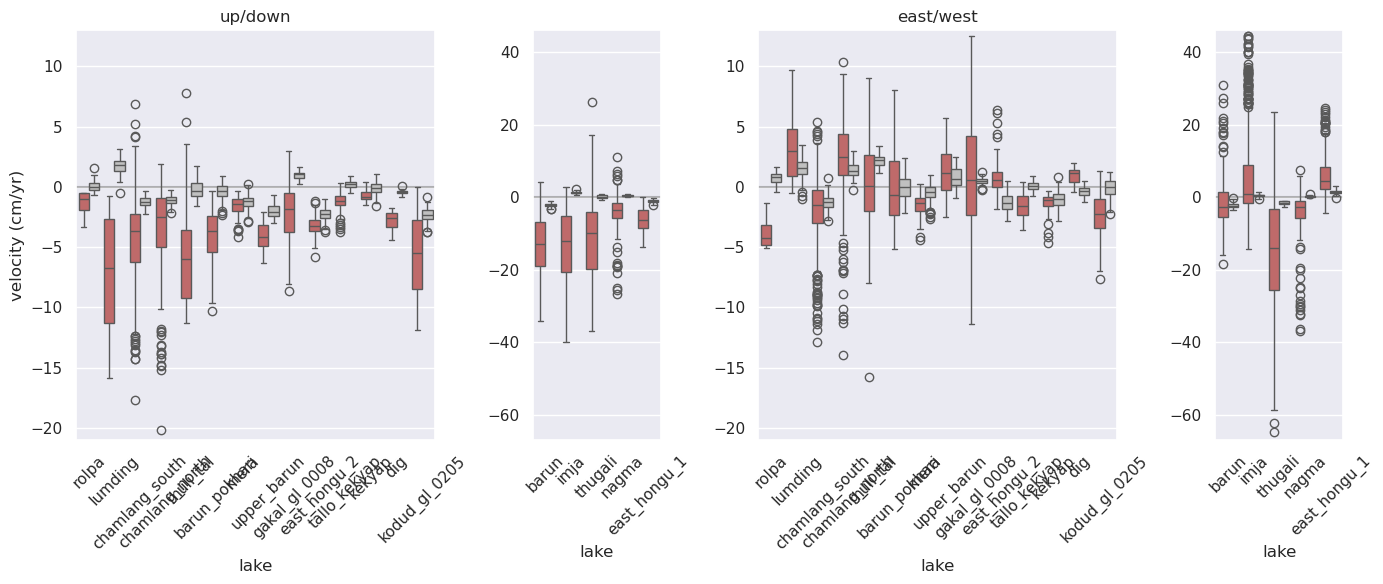

In [140]:
ud_dams_df = pd.DataFrame.from_dict(ud_veloc_all_dic, orient='index').transpose()
ud_dams_df['type'] = 'dam'
ud_stable_df = pd.DataFrame.from_dict(ud_veloc_all_stable_dic, orient='index').transpose()
ud_stable_df['type'] = 'stable'
ud_df = pd.concat([ud_dams_df, ud_stable_df])
ud_df_slow = ud_df.drop(['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1'], axis=1)
ud_df_slow = ud_df_slow.melt(id_vars='type')
ud_df_fast = ud_df[['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1', 'type']]
ud_df_fast = ud_df_fast.melt(id_vars='type')

ew_dams_df = pd.DataFrame.from_dict(ew_veloc_all_dic, orient='index').transpose()
ew_dams_df['type'] = 'dam'
ew_stable_df = pd.DataFrame.from_dict(ew_veloc_all_stable_dic, orient='index').transpose()
ew_stable_df['type'] = 'stable'
ew_df = pd.concat([ew_dams_df, ew_stable_df])
ew_df_slow = ew_df.drop(['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1'], axis=1)
ew_df_slow = ew_df_slow.melt(id_vars='type')
ew_df_fast = ew_df[['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1', 'type']]
ew_df_fast = ew_df_fast.melt(id_vars='type')

colors = ['indianred', 'silver']
slow_labels = ['rolpa', 'lumding','chamlang_south','chamlang_north',
               'muli_tal','barun_pokhari','mera','upper_barun','gakal_gl_0008',
               'east_hongu_2','tallo_kekyap','kekyap','dig','kodud_gl_0205']
fast_labels = ['barun', 'imja', 'thugali', 'nagma', 'east_hongu_1']

f, ax = plt.subplots(1, 4, figsize=(14, 6), gridspec_kw={'width_ratios': [2.8, 1, 2.8, 1]})
ax[0].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0], y='value', x='variable', hue='type', data=ud_df_slow, palette=colors, legend=False)
ax[0].set_title('up/down')
ax[0].set_xlabel('lake')
ax[0].set_ylim(-21, 13)
ax[0].set_ylabel('')
ax[0].set_ylabel('velocity (cm/yr)')
ax[0].set_xticklabels(slow_labels, rotation=45)

ax[1].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1], y='value', x='variable', hue='type', data=ud_df_fast, palette=colors, legend=False)
ax[1].set_xlabel('lake')
ax[1].set_ylim(-67, 46)
ax[1].set_ylabel('')
ax[1].set_xticklabels(fast_labels, rotation=45)

ax[2].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[2], y='value', x='variable', hue='type', data=ew_df_slow, palette=colors, legend=False)
ax[2].set_title('east/west')
ax[2].set_xlabel('lake')
ax[2].set_ylim(-21, 13)
ax[2].set_ylabel('')
ax[2].set_xticklabels(slow_labels, rotation=45)

ax[3].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[3], y='value', x='variable', hue='type', data=ew_df_fast, palette=colors, legend=False)
ax[3].set_xlabel('lake')
ax[3].set_ylim(-67, 46)
ax[3].set_ylabel('')
ax[3].set_xticklabels(fast_labels, rotation=45)

plt.tight_layout()
plt.savefig('figs/ud_ew_all_dams', dpi=300)

In [143]:
ud_df.barun.values

array([nan, nan, nan, ..., nan, nan, nan])

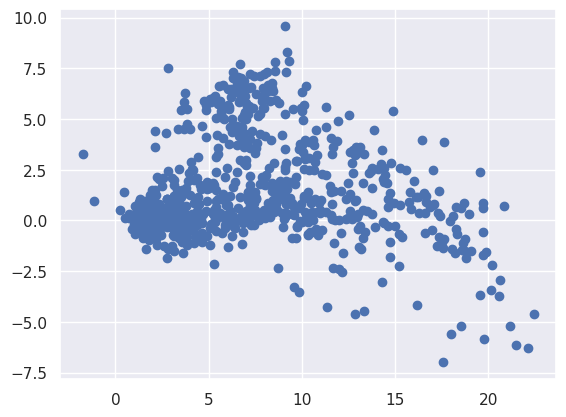

In [157]:
f, ax = plt.subplots()
ax.scatter(x=asc_df.east_hongu_1.values, y=des_df.east_hongu_1.values)

In [ ]:
asc_df = pd.DataFrame.from_dict({'dam':asc_veloc_sample*100, 'stable':asc_veloc_sample_stable*100}, orient='index').transpose()
des_df = pd.DataFrame.from_dict({'dam':des_veloc_sample*100, 'stable':des_veloc_sample_stable*100}, orient='index').transpose()
ud_df = pd.DataFrame.from_dict({'dam':ud_veloc_sample*100, 'stable':ud_veloc_sample_stable*100}, orient='index').transpose()
ew_df = pd.DataFrame.from_dict({'dam':ew_veloc_sample*100, 'stable':ew_veloc_sample_stable*100}, orient='index').transpose()
combined_df = pd.DataFrame.from_dict({'dam':combined_veloc_sample*100, 'stable':combined_veloc_sample_stable*100}, orient='index').transpose()
labels = ['dam', 'stable']
colors = ['indianred', 'silver']

sns.set_theme()

f, ax = plt.subplots(1, 4, figsize=(10, 4))
ax[0].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[0], data=asc_df, palette=colors, density_norm='area', common_norm=True, inner=None, cut=0)
sns.boxplot(ax=ax[0], data=asc_mean, palette=colors)
ax[0].set_xticklabels('')
ax[0].set_ylim(-60, 46)
ax[0].set_ylabel('mean velocity (cm/yr)')
ax[1].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[1], data=des_df, palette=colors, density_norm='area', common_norm=True, split=True, cut=0)
sns.boxplot(ax=ax[1], data=des_mean, palette=colors)
ax[1].set_xticklabels('')
ax[1].set_ylim(-60, 46)
ax[2].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[2], data=ud_df, palette=colors, density_norm='area', common_norm=True, split=True, cut=0)
sns.boxplot(ax=ax[2], data=ud_mean, palette=colors)
ax[2].set_xticklabels('')
ax[2].set_ylim(-60, 46)
ax[3].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[3], data=ew_df, palette=colors, density_norm='area', common_norm=True, split=True, cut=0)
sns.boxplot(ax=ax[3], data=ew_mean, palette=colors)
ax[3].set_xticklabels('')
ax[3].set_ylim(-60, 46)
# ax[4].axhline(0, c='k', alpha=0.3)
# sns.violinplot(ax=ax[4], data=combined_mean, palette=colors, split=True)
# ax[4].set_xticklabels('')
# ax[4].set_ylim(-63, 50)

plt.tight_layout()

plt.savefig('figs/velocity_boxplots.png', dpi=300)

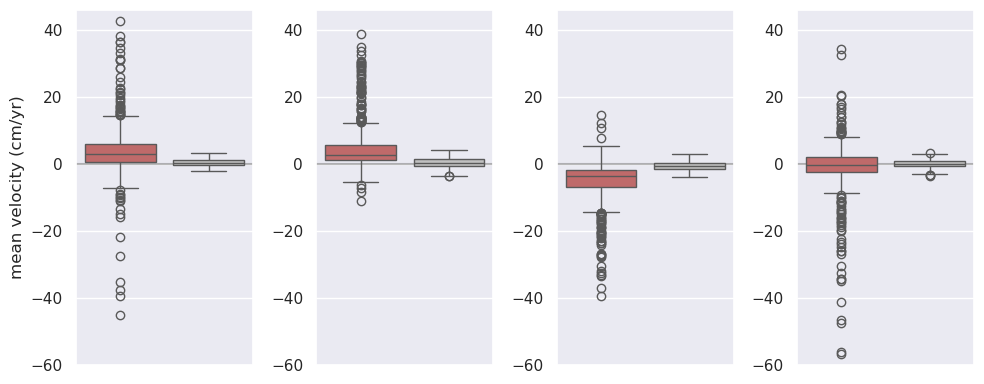

In [23]:
asc_df = pd.DataFrame.from_dict({'dam':asc_veloc_sample*100, 'stable':asc_veloc_sample_stable*100}, orient='index').transpose()
des_df = pd.DataFrame.from_dict({'dam':des_veloc_sample*100, 'stable':des_veloc_sample_stable*100}, orient='index').transpose()
ud_df = pd.DataFrame.from_dict({'dam':ud_veloc_sample*100, 'stable':ud_veloc_sample_stable*100}, orient='index').transpose()
ew_df = pd.DataFrame.from_dict({'dam':ew_veloc_sample*100, 'stable':ew_veloc_sample_stable*100}, orient='index').transpose()
combined_df = pd.DataFrame.from_dict({'dam':combined_veloc_sample*100, 'stable':combined_veloc_sample_stable*100}, orient='index').transpose()
labels = ['dam', 'stable']
colors = ['indianred', 'silver']

sns.set_theme()

f, ax = plt.subplots(1, 4, figsize=(10, 4))
ax[0].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[0], data=asc_df, palette=colors, density_norm='area', common_norm=True, inner=None, cut=0)
sns.boxplot(ax=ax[0], data=asc_df, palette=colors)
ax[0].set_xticklabels('')
ax[0].set_ylim(-60, 46)
ax[0].set_ylabel('mean velocity (cm/yr)')
ax[1].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[1], data=des_df, palette=colors, density_norm='area', common_norm=True, split=True, cut=0)
sns.boxplot(ax=ax[1], data=des_df, palette=colors)
ax[1].set_xticklabels('')
ax[1].set_ylim(-60, 46)
ax[2].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[2], data=ud_df, palette=colors, density_norm='area', common_norm=True, split=True, cut=0)
sns.boxplot(ax=ax[2], data=ud_df, palette=colors)
ax[2].set_xticklabels('')
ax[2].set_ylim(-60, 46)
ax[3].axhline(0, c='k', alpha=0.3)
#sns.violinplot(ax=ax[3], data=ew_df, palette=colors, density_norm='area', common_norm=True, split=True, cut=0)
sns.boxplot(ax=ax[3], data=ew_df, palette=colors)
ax[3].set_xticklabels('')
ax[3].set_ylim(-60, 46)
# ax[4].axhline(0, c='k', alpha=0.3)
# sns.violinplot(ax=ax[4], data=combined_mean, palette=colors, split=True)
# ax[4].set_xticklabels('')
# ax[4].set_ylim(-63, 50)

plt.tight_layout()

plt.savefig('figs/velocity_boxplots.png', dpi=300)

/tmp/ipykernel_783/2585015984.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/2585015984.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/2585015984.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/2585015984.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 3].set_xticklabels(labels, rotation=45)


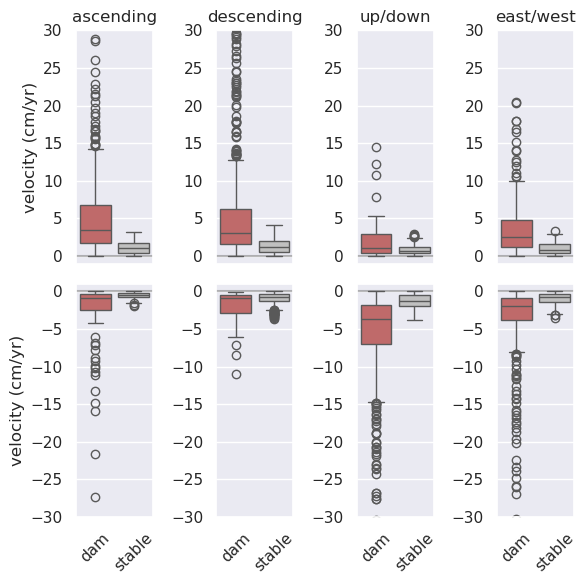

In [24]:
asc_pos_df = pd.DataFrame.from_dict({'dam':asc_veloc_sample[asc_veloc_sample>0]*100, 'stable':asc_veloc_sample_stable[asc_veloc_sample_stable>0]*100}, orient='index').transpose()
asc_neg_df = pd.DataFrame.from_dict({'dam':asc_veloc_sample[asc_veloc_sample<0]*100, 'stable':asc_veloc_sample_stable[asc_veloc_sample_stable<0]*100}, orient='index').transpose()
des_pos_df = pd.DataFrame.from_dict({'dam':des_veloc_sample[des_veloc_sample>0]*100, 'stable':des_veloc_sample_stable[des_veloc_sample_stable>0]*100}, orient='index').transpose()
des_neg_df = pd.DataFrame.from_dict({'dam':des_veloc_sample[des_veloc_sample<0]*100, 'stable':des_veloc_sample_stable[des_veloc_sample_stable<0]*100}, orient='index').transpose()
ud_pos_df = pd.DataFrame.from_dict({'dam':ud_veloc_sample[ud_veloc_sample>0]*100, 'stable':ud_veloc_sample_stable[ud_veloc_sample_stable>0]*100}, orient='index').transpose()
ud_neg_df = pd.DataFrame.from_dict({'dam':ud_veloc_sample[ud_veloc_sample<0]*100, 'stable':ud_veloc_sample_stable[ud_veloc_sample_stable<0]*100}, orient='index').transpose()
ew_pos_df = pd.DataFrame.from_dict({'dam':ew_veloc_sample[ew_veloc_sample>0]*100, 'stable':ew_veloc_sample_stable[ew_veloc_sample_stable>0]*100}, orient='index').transpose()
ew_neg_df = pd.DataFrame.from_dict({'dam':ew_veloc_sample[ew_veloc_sample<0]*100, 'stable':ew_veloc_sample_stable[ew_veloc_sample_stable<0]*100}, orient='index').transpose()
labels = ['dam', 'stable']
colors = ['indianred', 'silver']

sns.set_theme()

f, ax = plt.subplots(2, 4, figsize=(6, 6))
ax[0, 0].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 0], data=asc_pos_df, palette=colors)
ax[0, 0].set_xticklabels('')
ax[0, 0].set_ylim(-1, 30)
ax[0, 0].set_ylabel('velocity (cm/yr)')
ax[0, 0].set_title('ascending')
ax[1, 0].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 0], data=asc_neg_df, palette=colors)
ax[1, 0].set_xticklabels('')
ax[1, 0].set_ylim(-30, 1)
ax[1, 0].set_ylabel('velocity (cm/yr)')
ax[1, 0].set_xticklabels(labels, rotation=45)

ax[0, 1].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 1], data=des_pos_df, palette=colors)
ax[0, 1].set_xticklabels('')
ax[0, 1].set_ylim(-1, 30)
ax[0, 1].set_title('descending')
ax[1, 1].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 1], data=des_neg_df, palette=colors)
ax[1, 1].set_xticklabels('')
ax[1, 1].set_ylim(-30, 1)
ax[1, 1].set_xticklabels(labels, rotation=45)

ax[0, 2].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 2], data=ud_pos_df, palette=colors)
ax[0, 2].set_xticklabels('')
ax[0, 2].set_ylim(-1, 30)
ax[0, 2].set_title('up/down')
ax[1, 2].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 2], data=ud_neg_df, palette=colors)
ax[1, 2].set_xticklabels('')
ax[1, 2].set_ylim(-30, 1)
ax[1, 2].set_xticklabels(labels, rotation=45)

ax[0, 3].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 3], data=ew_pos_df, palette=colors)
ax[0, 3].set_xticklabels('')
ax[0, 3].set_ylim(-1, 30)
ax[0, 3].set_title('east/west')
ax[1, 3].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 3], data=ew_neg_df, palette=colors)
ax[1, 3].set_xticklabels('')
ax[1, 3].set_ylim(-30, 1)
ax[1, 3].set_xticklabels(labels, rotation=45)


plt.tight_layout()

plt.savefig('figs/velocity_boxplots_sample.png', dpi=300)

/tmp/ipykernel_783/481386913.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/481386913.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/481386913.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/481386913.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 3].set_xticklabels(labels, rotation=45)


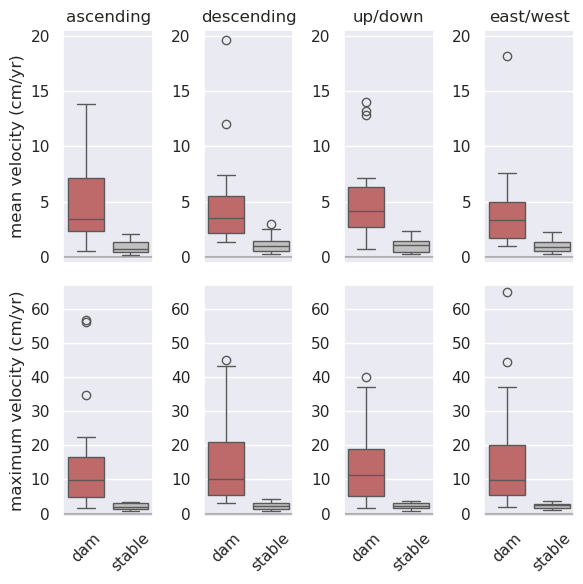

In [27]:
asc_mean = md_df[['asc_mean_veloc', 'asc_mean_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
des_mean = md_df[['des_mean_veloc', 'des_mean_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
ud_mean = md_df[['ud_mean_veloc', 'ud_mean_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
ew_mean = md_df[['ew_mean_veloc', 'ew_mean_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
asc_max = md_df[['asc_max_veloc', 'asc_max_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
des_max = md_df[['des_max_veloc', 'des_max_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
ud_max = md_df[['ud_max_veloc', 'ud_max_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
ew_max = md_df[['ew_max_veloc', 'ew_max_veloc_stable']].where(md_df.asc_mean_veloc > 0)*100
labels = ['dam', 'stable']
colors = ['indianred', 'silver']

sns.set_theme()

f, ax = plt.subplots(2, 4, figsize=(6, 6))
ax[0, 0].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 0], data=asc_mean, palette=colors)
ax[0, 0].set_xticklabels('')
ax[0, 0].set_ylim(-0.5, 20.5)
ax[0, 0].set_ylabel('mean velocity (cm/yr)')
ax[0, 0].set_title('ascending')
ax[0, 1].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 1], data=des_mean, palette=colors)
ax[0, 1].set_xticklabels('')
ax[0, 1].set_ylim(-0.5, 20.5)
ax[0, 1].set_title('descending')
ax[0, 2].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 2], data=ud_mean, palette=colors)
ax[0, 2].set_xticklabels('')
ax[0, 2].set_ylim(-0.5, 20.5)
ax[0, 2].set_title('up/down')
ax[0, 3].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[0, 3], data=ew_mean, palette=colors)
ax[0, 3].set_xticklabels('')
ax[0, 3].set_ylim(-0.5, 20.5)
ax[0, 3].set_title('east/west')
ax[1, 0].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 0], data=asc_max, palette=colors)
ax[1, 0].set_xticklabels(labels, rotation=45)
ax[1, 0].set_ylim(-1, 67)
ax[1, 0].set_ylabel('maximum velocity (cm/yr)')
ax[1, 1].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 1], data=des_max, palette=colors)
ax[1, 1].set_xticklabels(labels, rotation=45)
ax[1, 1].set_ylim(-1, 67)
ax[1, 2].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 2], data=ud_max, palette=colors)
ax[1, 2].set_xticklabels(labels, rotation=45)
ax[1, 2].set_ylim(-1, 67)
ax[1, 3].axhline(0, c='k', alpha=0.3)
sns.boxplot(ax=ax[1, 3], data=ew_max, palette=colors)
ax[1, 3].set_xticklabels(labels, rotation=45)
ax[1, 3].set_ylim(-1, 67)

plt.tight_layout()

plt.savefig('figs/velocity_boxplots.png', dpi=300)

/tmp/ipykernel_783/3314785683.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/3314785683.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/3314785683.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_783/3314785683.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 3].set_xticklabels(labels, rotation=45)


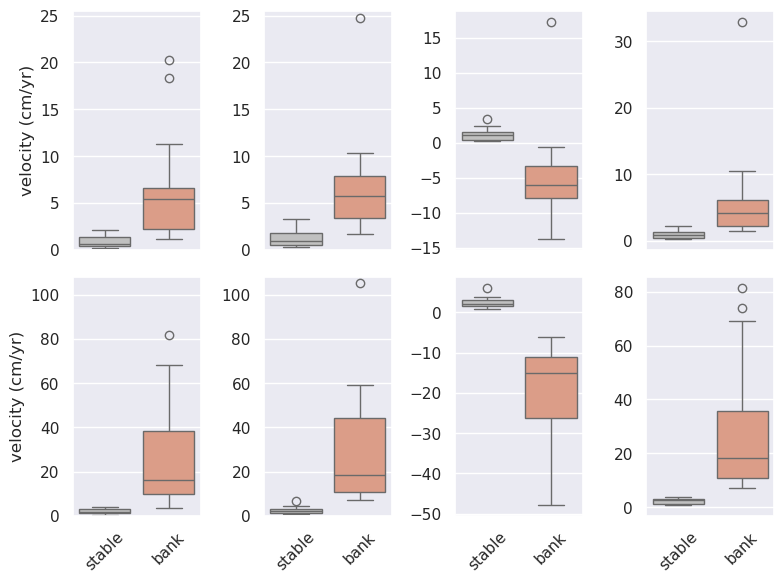

In [28]:
asc_mean = md_df[['asc_mean_veloc_stable', 'asc_mean_veloc_bank']]*100
des_mean = md_df[['des_mean_veloc_stable', 'des_mean_veloc_bank']]*100
ud_mean = md_df[['ud_mean_veloc_stable', 'ud_mean_veloc_bank']]*100
ew_mean = md_df[['ew_mean_veloc_stable', 'ew_mean_veloc_bank']]*100
asc_max = md_df[['asc_max_veloc_stable', 'asc_max_veloc_bank']]*100
des_max = md_df[['des_max_veloc_stable', 'des_max_veloc_bank']]*100
ud_max = md_df[['ud_max_veloc_stable', 'ud_max_veloc_bank']]*100
ew_max = md_df[['ew_max_veloc_stable', 'ew_max_veloc_bank']]*100
labels = ['stable', 'bank']
colors = ['silver', 'darksalmon']

sns.set_theme()

f, ax = plt.subplots(2, 4, figsize=(8, 6))
sns.boxplot(ax=ax[0, 0], data=asc_mean, palette=colors)
ax[0, 0].set_xticklabels('')
ax[0, 0].set_ylim(0, 25.5)
ax[0, 0].set_ylabel('velocity (cm/yr)')
sns.boxplot(ax=ax[0, 1], data=des_mean, palette=colors)
ax[0, 1].set_xticklabels('')
ax[0, 1].set_ylim(0, 25.5)
sns.boxplot(ax=ax[0, 2], data=ud_mean, palette=colors)
ax[0, 2].set_xticklabels('')
sns.boxplot(ax=ax[0, 3], data=ew_mean, palette=colors)
ax[0, 3].set_xticklabels('')
sns.boxplot(ax=ax[1, 0], data=asc_max, palette=colors)
ax[1, 0].set_xticklabels(labels, rotation=45)
ax[1, 0].set_ylim(0, 108)
ax[1, 0].set_ylabel('velocity (cm/yr)')
sns.boxplot(ax=ax[1, 1], data=des_max, palette=colors)
ax[1, 1].set_xticklabels(labels, rotation=45)
ax[1, 1].set_ylim(0, 108)
sns.boxplot(ax=ax[1, 2], data=ud_max, palette=colors)
ax[1, 2].set_xticklabels(labels, rotation=45)
sns.boxplot(ax=ax[1, 3], data=ew_max, palette=colors)
ax[1, 3].set_xticklabels(labels, rotation=45)
plt.tight_layout()

plt.savefig('figs/velocity_boxplots.png', dpi=300)

In [ ]:
lake_elev_dic = {
    'rolpa': 4545.5,
    'barun': 4507.5,
    'imja': 4990,
    'lumding': 4831,
    'chamlang_south': 4938,
    'thugali': 3988,
    'nagma': 4910,
    'chamlang_north': 5206,
    'muli_tal': 5577,
    'barun_pokhari': 4808.5,
    'east_hongu_1': 5379.5,
    'birendra': 3623,
    'mera': 5251.5,
    'upper_barun': 5185.5,
    'gakal_gl_0008': 5436,
    'kotam_gl_0111': 4902,
    'east_hongu_2': 5480.5,
    'tallo_kekyap': 5422,
    'kekyap': 5479,
    'dig': 4370,
    'sabai': 4363,
    'kodud_gl_0205': 4759,
    'hongu_1': 5204
}

md_df['lake_elev'] = md_df['survey_name'].map(lake_elev_dic)                                    

In [54]:
pfv_dic = {
    'rolpa': 66.3,
    'barun': 1.5,
    'imja': 0.4,
    'lumding': 21.4,
    'chamlang_south': 9.3,
    'thugali': 0.7,
    'nagma': 0.7,
    'chamlang_north': 29.6,
    'muli_tal': 0.2,
    'barun_pokhari': 0.7,
    'east_hongu_1': 2.6,
    'birendra': 0.7,
    'mera': 2.4,
    'upper_barun': 1.5,
    'gakal_gl_0008': 0.2,
    'kotam_gl_0111': 2.7,
    'east_hongu_2': 2.6,
    'tallo_kekyap': 0.2,
    'kekyap': 0.2,
    'dig': 0.7,
    'sabai': 2.3,
    'kodud_gl_0205': 6.0,
    'hongu_1': 4.6
}

md_df['pfv'] = md_df['survey_name'].map(pfv_dic)

In [9]:
md_df['moving_proportion'] = md_df['moving_area']/md_df['area']
md_df['mean_freeboard'] = md_df['mean_elevation'] - md_df['lake_elev']

In [60]:
md_df['mask_area_proportion'] = md_df['combined_mask_area']/md_df['area']

In [71]:
(md_df.ud_max_veloc*100).mean()

14.556240944397937

In [ ]:
md_df['shapefile_names'] = md_df['survey_name']+'_md'

In [ ]:
md_df.to_csv('md_df.csv')